<a href="https://colab.research.google.com/github/kintel/iree/blob/colab/mnist_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Copyright 2020 The IREE Authors

Licensed under the Apache License v2.0 with LLVM Exceptions.
See https://llvm.org/LICENSE.txt for license information.
SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception
```


# MNIST Model TensorFlow Training, IREE Execution

## Overview

This notebook creates and trains a TensorFlow 2.0 model for recognizing handwritten digits using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), then compiles and executes that trained model using IREE.

## Running Locally

*  Refer to [using_colab.md](https://google.github.io/iree/using-iree/using-colab) for general information
*  Ensure that you have a recent version of TensorFlow 2.0 [installed on your system](https://www.tensorflow.org/install)
*  Enable IREE/TF integration by adding to your user.bazelrc: `build --define=iree_tensorflow=true`
*  Start colab by running `python colab/start_colab_kernel.py` (see that file for additional instructions)
*  Note: you may need to restart your runtime in order to re-run certain cells. Some of the APIs are not yet stable enough for repeated invocations

## 1. Install and Import IREE

In [ ]:
!python -m pip install iree-compiler-snapshot iree-runtime-snapshot iree-tools-tf-snapshot -f https://github.com/google/iree/releases

Looking in links: https://github.com/google/iree/releases
     |████████████████████████████████| 33.8MB 90kB/s 
     |████████████████████████████████| 481kB 50.7MB/s 
     |████████████████████████████████| 53.8MB 58kB/s 


In [ ]:
from iree import runtime as ireert
from iree.runtime import version as runtime_version
from iree.tf.support import module_utils
from iree.compiler import tf as tfc
from iree.compiler import version as compiler_version

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


plt.style.use("seaborn-whitegrid")
plt.rcParams["font.family"] = "monospace"
plt.rcParams["figure.figsize"] = [8, 4.5]
plt.rcParams["figure.dpi"] = 150

# Print version information for future notebook users to reference.
print(f'TensorFlow version: {tf.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'IREE compiler version: {compiler_version.VERSION}')
print(f'IREE runtime version: {runtime_version.VERSION}')


TensorFlow version: 2.5.0
Numpy version: 1.19.5
IREE compiler version: 20210615.342
IREE runtime version: 20210615.342


# Create and Train MNIST Model in TensorFlow

The specific details of the training process here aren't critical to the model compilation and execution through IREE.

Sample image from the dataset:


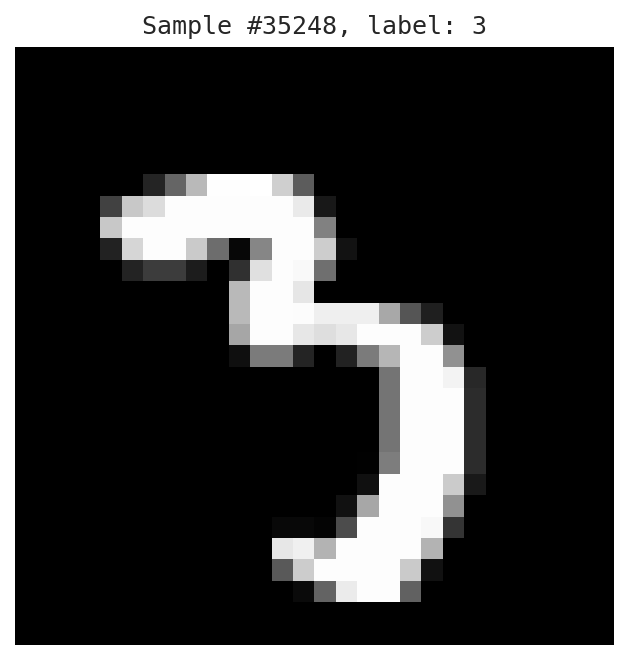

In [ ]:
#@title Load MNIST dataset, setup training and evaluation

# Keras datasets don't provide metadata.
NUM_CLASSES = 10
NUM_ROWS, NUM_COLS = 28, 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape into grayscale images:
x_train = np.reshape(x_train, (-1, NUM_ROWS, NUM_COLS, 1))
x_test = np.reshape(x_test, (-1, NUM_ROWS, NUM_COLS, 1))

# Rescale uint8 pixel values into floats:
x_train = x_train / 255
x_test = x_test / 255

# Explicitly cast to float32 because numpy defaults to double precision and
# IREE uses single precision:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print("Sample image from the dataset:")
sample_index = np.random.randint(x_train.shape[0])
plt.imshow(x_train[sample_index].reshape(NUM_ROWS, NUM_COLS), cmap="gray")
plt.title(f"Sample #{sample_index}, label: {y_train[sample_index]}")
plt.axis("off")
plt.tight_layout()

In [ ]:
#@title Define a DNN model using tf.keras API

def simple_dnn(num_classes):
  """Creates a simple multi-layer perceptron model."""

  model = tf.keras.models.Sequential()
  # Flatten to a 1d array (e.g. 28x28x1 -> 784).
  model.add(tf.keras.layers.Flatten())
  # Fully-connected neural layer with 128 neurons, RELU activation.
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  # Fully-connected neural layer returning probability scores for each class.
  model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
  return model

In [ ]:
#@markdown ### Training Parameters

batch_size = 32  #@param { type: "slider", min: 10, max: 400 }
num_epochs = 8    #@param { type: "slider", min:  1, max:  20 }

In [ ]:
#@title Train the Keras model

tf_model = simple_dnn(NUM_CLASSES)
# Stateful optimizers like Adam create variable incompatible with compilation as
# currently implemented.
tf_model.compile(
    optimizer="sgd", loss="sparse_categorical_crossentropy", metrics="accuracy")
tf_model.fit(x_train, y_train, batch_size, num_epochs, validation_split=0.1)

Epoch 1/8
1688/1688 [==============================] - 4s 2ms/step - loss: 0.7009 - accuracy: 0.8235 - val_loss: 0.3249 - val_accuracy: 0.9143
Epoch 2/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3541 - accuracy: 0.9016 - val_loss: 0.2648 - val_accuracy: 0.9263
Epoch 3/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3050 - accuracy: 0.9142 - val_loss: 0.2335 - val_accuracy: 0.9333
Epoch 4/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2756 - accuracy: 0.9219 - val_loss: 0.2152 - val_accuracy: 0.9390
Epoch 5/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2528 - accuracy: 0.9290 - val_loss: 0.2039 - val_accuracy: 0.9445
Epoch 6/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2343 - accuracy: 0.9340 - val_loss: 0.1867 - val_accuracy: 0.9495
Epoch 7/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2181 - accuracy: 0.9389 - val_loss: 0.1758 - val_accuracy: 0.9543

# Compile and Execute MNIST Model using IREE

In [ ]:
#@title Wrap the model in a tf.Module with IREE-compatible settings and convert to MLIR.

# Since the model was written in sequential style, explicitly wrap in a module.
inference_module = tf.Module()
inference_module.model = tf_model

# Hack: Convert to static shape. Won't be necessary once dynamic shapes are in.
input_shape = list(tf_model.inputs[0].shape)
input_shape[0] = 1  # Make fixed (batch=1)

# Produce a concrete function to compile.
inference_module.predict = tf.function(input_signature=[
    tf.TensorSpec(input_shape, tf_model.inputs[0].dtype)
])(lambda x: tf_model.call(x, training=False))

# Only try to compile the function we care about:
exported_names = ["predict"]

In [ ]:
#@markdown ### Backend Configuration

backend_choice = "llvmaot (CPU)" #@param [ "vmvx (CPU)", "llvmaot (CPU)", "vulkan (GPU/SwiftShader – requires additional drivers) " ]
backend_choice = f"iree_{backend_choice.split(' ')[0]}"
backend = module_utils.BackendInfo(backend_choice)

In [ ]:
iree_module = module_utils.IreeCompiledModule.create_from_instance(
    inference_module, backend, exported_names)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /tmp/tmp7dxwzhej.sm/assets


2021-06-18 17:26:41.282658: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:37] Reading SavedModel from: /tmp/tmp7dxwzhej.sm
2021-06-18 17:26:41.284022: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:60] Reading SavedModel debug info (if present) from: /tmp/tmp7dxwzhej.sm
2021-06-18 17:26:41.339564: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Created IREE driver dylib: <iree.runtime.binding.HalDriver object at 0x7fc34943bd70>
SystemContext driver=<iree.runtime.binding.HalDriver object at 0x7fc34943bd70>


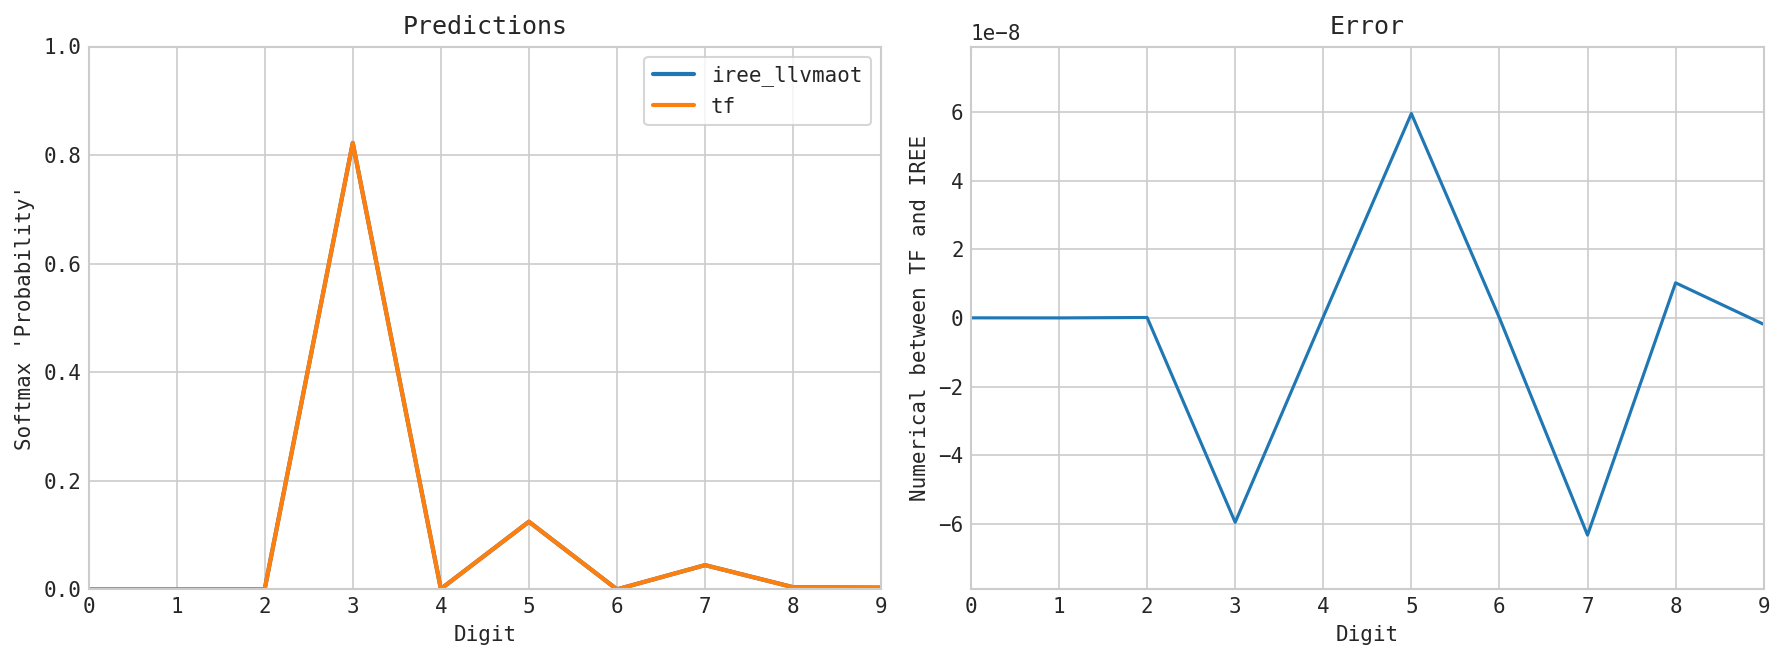

In [ ]:
# Invoke the 'predict' function with a single image as an argument
iree_prediction = iree_module.predict(x_train[sample_index][None, :])[0]
tf_prediction = tf_model.predict(x_train[sample_index][None, :])[0]
error = tf_prediction - iree_prediction

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(12)

ax = axs[0]
ax.plot(iree_prediction, linewidth=2, label=backend.backend_name)
ax.plot(tf_prediction, linewidth=2, label="tf")

ax.set_title("Predictions")
ax.set_ylabel("Softmax 'Probability'")
ax.set_xlabel("Digit")
ax.set_ylim(0, 1)
ax.set_xlim(0, 9)
ax.legend(frameon=True)


ax = axs[1]
ax.plot(error)

ax.set_title("Error")
ax.set_ylabel("Numerical between TF and IREE")
ax.set_xlabel("Digit")
ylim = 1.25 * np.max(np.abs(error))
ax.set_ylim(-ylim, ylim)
ax.set_xlim(0, 9)

fig.tight_layout()

In [ ]:
#@title Evaluate the network on the test data.
accuracies = []

for index in range(x_test.shape[0]):
  input = x_test[index]
  label = y_test[index]

  prediction = iree_module.predict(input[None, :])
  prediction = np.argmax(prediction, -1)
  accuracies.append(np.sum(prediction == label))

accuracy = np.mean(accuracies)
print(f"Test accuracy: {accuracy:.3f}")

Test accuracy: 0.944


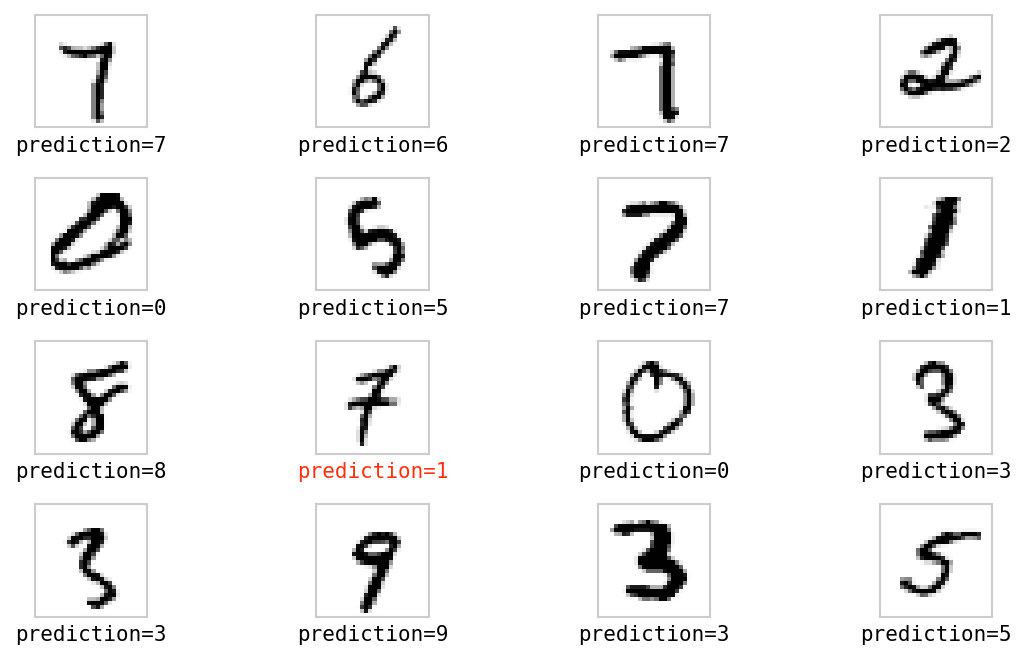

In [ ]:
import random

rows = 4
columns = 4
images_to_display = rows * columns

random_indices = np.random.randint(0, x_test.shape[0], images_to_display)

predictions = []
for i in range(images_to_display):
  p = iree_module.predict(x_test[random_indices[i]][None, :])
  predictions.append(np.argmax(p, -1)[0])

fig, axs = plt.subplots(rows, columns)

for i, ax in enumerate(np.ndarray.flatten(axs)):
  ax.imshow(x_test[random_indices[i], :, :, 0])
  color = "#000000" if predictions[i] == y_test[random_indices[i]] else "#ff300e"
  ax.set_xlabel(f"prediction={predictions[i]}", color=color)
  ax.grid(False)
  ax.set_yticks([])
  ax.set_xticks([])

fig.tight_layout()